# 0. Introduction

**Dataset**  
- KDD  
  \*[TCP packet 데이터셋과 그에 대한 connection(bad or good(normal))](https://kdd.ics.uci.edu/databases/kddcup99/task.html)

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- VAE 모델을 Normal 통신의 TCP packet 데이터로 학습시키고, 이후에 Normal과 Attack 통신의 TCP packet이 혼합되어 모델에 들어올 때 이에 대해서 Normal / Attack 여부를 탐지할 수 있도록 함

**References**
- [AI-class/KDD_VAE.ipynb at main · MyungKyuYi/AI-class](https://github.com/MyungKyuYi/AI-class/blob/main/KDD_VAE.ipynb)
- [KDD-CUP-99 Task Description](https://kdd.ics.uci.edu/databases/kddcup99/task.html)

**Performance(accuracy)**  
- \-

`tf.compat.v1.disable_eager_execution()`은 TensorFlow에서 **즉시 실행(Eager Execution)**을 비활성화하는 함수입니다. TensorFlow 2.x 버전에서는 **즉시 실행 모드(Eager Execution)**가 기본적으로 활성화되어 있습니다. 이 함수는 TensorFlow 1.x 스타일의 그래프 실행 모드(즉, 지연 실행 또는 Declarative Execution)로 전환하는 데 사용됩니다.

---

### 1. **즉시 실행(Eager Execution)**
- **기본 모드(TensorFlow 2.x)**:  
  연산이 호출되면 즉시 실행됩니다.
- **특징**:
  - Python 코드처럼 직관적이고 디버깅이 쉽습니다.
  - 함수 호출 후 바로 결과를 확인할 수 있습니다.
  - 그러나 그래프를 미리 정의하지 않기 때문에 성능이 약간 저하될 수 있습니다.

---

### 2. **지연 실행(Graph Execution)**
- TensorFlow 1.x에서 사용되던 방식입니다.
- 계산 그래프(Computation Graph)를 먼저 정의한 다음, 그래프를 `Session` 객체로 실행해야 결과를 얻을 수 있습니다.
- **특징**:
  - 성능이 더 최적화될 수 있습니다.
  - 코드가 더 복잡하고 디버깅이 어렵습니다.

---

### 3. **`tf.compat.v1.disable_eager_execution()` 사용 목적**
이 함수는 **TensorFlow 2.x 환경에서 1.x 스타일 코드를 사용하려는 경우**에 유용합니다. 

#### 주요 사용 사례:
1. **TensorFlow 1.x 코드를 실행**:
   - 기존의 TensorFlow 1.x 코드를 변환 없이 실행할 때 사용됩니다.
   - TensorFlow 2.x에서 Session 객체 기반 코드를 실행하려면 Eager Execution을 비활성화해야 합니다.
   
   예제:
   ```python
   import tensorflow as tf
   tf.compat.v1.disable_eager_execution()

   # Define a simple computation graph
   a = tf.compat.v1.placeholder(tf.float32)
   b = tf.compat.v1.placeholder(tf.float32)
   c = a + b

   with tf.compat.v1.Session() as sess:
       print(sess.run(c, feed_dict={a: 1.0, b: 2.0}))  # Output: 3.0
   ```

2. **성능 최적화**:
   - 일부 상황에서 그래프 실행(Graph Execution)이 즉시 실행보다 성능이 더 나을 수 있습니다.

3. **호환성 유지**:
   - TensorFlow 1.x에 종속적인 라이브러리나 코드를 사용해야 할 때 필요합니다.

---

### 4. **주의점**
- TensorFlow 2.x의 주요 기능(예: `tf.function`)은 Eager Execution에 의존하므로, 이 함수는 **TensorFlow 2.x의 기능을 제한**할 수 있습니다.
- 새로운 프로젝트에서는 Eager Execution을 유지하는 것이 일반적으로 더 권장됩니다.

### 5. **대안**
대부분의 경우 TensorFlow 2.x 스타일의 코드(즉시 실행 기반)를 사용하는 것이 바람직하며, `tf.function` 데코레이터를 사용하여 그래프 실행의 성능 최적화를 구현할 수 있습니다:
```python
@tf.function
def add(a, b):
    return a + b

print(add(1.0, 2.0).numpy())  # Output: 3.0
```

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # TensorFlow 2.x에서 1.x의 레거시 코드를 사용해야 될 때 사용
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models, backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from datetime import datetime

%matplotlib inline

2024-11-19 15:03:20.733171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [3]:
df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']

df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

In [4]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,status
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [6]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'status'],
      dtype='object')

In [7]:
# object type의 label 종류
object_features = ['protocol_type', 'service', 'flag']
for of in object_features:
    print(f"<{of}> {np.unique(df[of])}")
    # print(f'{of<:15}: {np.unique(df[of])}')

<protocol_type> ['icmp' 'tcp' 'udp']
<service> ['IRC' 'X11' 'Z39_50' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf' 'daytime'
 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs' 'exec'
 'finger' 'ftp' 'ftp_data' 'gopher' 'hostnames' 'http' 'http_443' 'imap4'
 'iso_tsap' 'klogin' 'kshell' 'ldap' 'link' 'login' 'mtp' 'name'
 'netbios_dgm' 'netbios_ns' 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u'
 'other' 'pm_dump' 'pop_2' 'pop_3' 'printer' 'private' 'red_i'
 'remote_job' 'rje' 'shell' 'smtp' 'sql_net' 'ssh' 'sunrpc' 'supdup'
 'systat' 'telnet' 'tftp_u' 'tim_i' 'time' 'urh_i' 'urp_i' 'uucp'
 'uucp_path' 'vmnet' 'whois']
<flag> ['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH']


In [8]:
# status 종류 및 인코딩 값
statuses = np.unique(df['status'], return_counts=True)
print(f'{"<status>":<18} {"<counts>":<10} <encoded_label>')
for i in range(len(statuses[0])):
    el = "1*****" if statuses[0][i] == 'normal.' else 0
    print(f'{statuses[0][i]:<18} {statuses[1][i]:<10} {el}')

# if encoded_label == 0 'attack data' else 'normal data'
# labels 변수에 인코딩해서 보관하고 있음

<status>           <counts>   <encoded_label>
back.              2203       0
buffer_overflow.   30         0
ftp_write.         8          0
guess_passwd.      53         0
imap.              12         0
ipsweep.           1247       0
land.              21         0
loadmodule.        9          0
multihop.          7          0
neptune.           107201     0
nmap.              231        0
normal.            97278      1*****
perl.              3          0
phf.               4          0
pod.               264        0
portsweep.         1040       0
rootkit.           10         0
satan.             1589       0
smurf.             280790     0
spy.               2          0
teardrop.          979        0
warezclient.       1020       0
warezmaster.       20         0


In [9]:
# 121개의 샘플데이터
# label로 사용할 'status' 제외
# Object type인 'protocol_type', 'service', 'flag'에 대해서 
# 0과 1로 표현할 수 있도록 변환
# ex. 기존) protocol_type = icmp
#     변환) protocol_type_icmp = 1, protocol_type_tcp = 0, protocol_type_udp = 0
samples

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_S3,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_guest_login_0,is_guest_login_1
0,0,181,5450,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
1,0,239,486,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
2,0,235,1337,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
3,0,219,1337,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
4,0,217,2032,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
494017,0,282,2286,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
494018,0,203,1200,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False
494019,0,291,1200,0,0,0,0,0,0,0,...,False,True,False,True,False,False,True,True,True,False


In [10]:
# Object type의 column을 모두 분할한 후의 columns
print(len(samples.columns))
for column in samples.columns:
    print(column)

121
duration
src_bytes
dst_bytes
wrong_fragment
urgent
hot
num_failed_logins
num_compromised
root_shell
su_attempted
num_root
num_file_creations
num_shells
num_access_files
num_outbound_cmds
count
srv_count
serror_rate
srv_serror_rate
rerror_rate
srv_rerror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_serror_rate
dst_host_srv_serror_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate
protocol_type_icmp
protocol_type_tcp
protocol_type_udp
service_IRC
service_X11
service_Z39_50
service_auth
service_bgp
service_courier
service_csnet_ns
service_ctf
service_daytime
service_discard
service_domain
service_domain_u
service_echo
service_eco_i
service_ecr_i
service_efs
service_exec
service_finger
service_ftp
service_ftp_data
service_gopher
service_hostnames
service_http
service_http_443
service_imap4
service_iso_tsap
service_klogin
service_kshell


In [11]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [12]:
# normal sample(1)과 attack sample(0)을 구분

# labels에서 1인 rownum을 df_scaled에 매칭하여 추출
norm_samples = df_scaled[labels == 1]
# labels에서 0인 rownum을 df_scaled에 매칭하여 추출
attack_samples = df_scaled[labels == 0]
# label값이 1 즉, normal인 label만 추출
norm_labels = labels[labels == 1]
# label값이 0 즉, attack인 label만 추출
attack_labels = labels[labels == 0]

print(f'normal(1): {norm_samples.shape} {norm_labels.shape}')
print(f'attack(0): {attack_samples.shape} {attack_labels.shape}')

normal(1): (97278, 121) (97278,)
attack(0): (396743, 121) (396743,)


In [13]:
# Train set 분리
# training은 normal sample로만 진행

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm) # 전체의 80% 만큼을 training set으로 사용
X_train = norm_samples[:len_norm_train]

In [14]:
# Test set 만들기
# test set의 50%는 normal(1), 50%는 attack(0)으로 구성

X_test_norm = norm_samples[len_norm_train:] # 위에서 쓰고 남은 normal samples
len_attack_test = len(X_test_norm) # attack sample의 수도 normal과 동일하게 맞춰줌
X_test_attack = attack_samples[:len_attack_test]

# 합치기
X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test)) # label은 일단 다 1로 설정하고,
y_test[len(X_test_norm):] = 0 # 0인 부분은 0으로 설정

#### 내 의문을 해소하는 방향으로 처리했음.
### 의문: 마지막 코드를 [len(X_test_norm):]로 설정해야 되는 거 아닌가?
### 그 위 코드에서 모두 1로 설정하고, 그 다음에 attack인 부분만 0으로 설정하는 코드 같은데,
### 그러면 :len(X_test_norm)이 아니고, len(X_test_norm): 아닌가?

In [15]:
# encoder model training 구조 짜기
# 결국 latent space를 만들어 내는 encoder 구조임을 알면 된다

original_dim = X_train.shape[1] # X_train.shape: (77882, 121)
input_shape = (original_dim,)
intermidiate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [16]:
def sample(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

In [17]:
# encoder model
inputs = Input(shape=input_shape,
               name='encoder_input')
x = Dense(intermidiate_dim, activation='relu')(inputs)
# 확률 분포 latent를 만드는 과정 - mean
z_mean = Dense(latent_dim,
               name='z_mean')(x)
# 확률 분포 latent를 만드는 과정 - variance
z_log_var = Dense(latent_dim,
                  name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, outputs = [z, z_mean, z_log_var], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 121)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 60)           7320        ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 40)           2440        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 40)           2440        ['dense[0][0]']                  
                                                                                            

In [18]:
# decoder model
latent_inputs = Input(shape=(latent_dim,),
                      name='z_sampling')
x = Dense(intermidiate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs,
               name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 40)]              0         
                                                                 
 dense_1 (Dense)             (None, 60)                2460      
                                                                 
 dense_2 (Dense)             (None, 121)               7381      
                                                                 
Total params: 9,841
Trainable params: 9,841
Non-trainable params: 0
_________________________________________________________________


In [19]:
outputs = decoder(encoder(inputs)[0])
vae_model = Model(inputs, outputs,
                  name='vae_mlp')

vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 121)]             0         
                                                                 
 encoder (Functional)        [(None, 40),              12200     
                              (None, 40),                        
                              (None, 40)]                        
                                                                 
 decoder (Functional)        (None, 121)               9841      
                                                                 
Total params: 22,041
Trainable params: 22,041
Non-trainable params: 0
_________________________________________________________________


In [20]:
# loss를 따로 정의해줘야 됨. 
# reconstruction loss + Divergence loss
def vae_loss(x, y):
    x_encoded_mean, z_mean, z_log_sigma = encoder(x)
    x_decoded_mean = decoder(x_encoded_mean)
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001 # KLD에 가중치를 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    
    return total_loss

In [21]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 121)]             0         
                                                                 
 encoder (Functional)        [(None, 40),              12200     
                              (None, 40),                        
                              (None, 40)]                        
                                                                 
 decoder (Functional)        (None, 121)               9841      
                                                                 
Total params: 22,041
Trainable params: 22,041
Non-trainable params: 0
_________________________________________________________________


In [22]:
# VAE 모델 학습
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        validation_split=0.1,
                        epochs=64,
                        batch_size=256)

Train on 70039 samples, validate on 7783 samples
Epoch 1/64


2024-11-19 15:03:35.730976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 15:03:35.755961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


70039/70039 [==============================] - 1s 14us/sample - loss: 17.2448 - val_loss: 6.2577
Epoch 2/64
11776/70039 [====>.........................] - ETA: 0s - loss: 2.4638

/opt/anaconda3/envs/gc_dl/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


70039/70039 [==============================] - 1s 9us/sample - loss: 1.8546 - val_loss: 5.2244
Epoch 3/64
70039/70039 [==============================] - 1s 9us/sample - loss: 1.5260 - val_loss: 4.7049
Epoch 4/64
70039/70039 [==============================] - 1s 9us/sample - loss: 1.3295 - val_loss: 3.6742
Epoch 5/64
70039/70039 [==============================] - 1s 9us/sample - loss: 0.9743 - val_loss: 2.3864
Epoch 6/64
70039/70039 [==============================] - 1s 9us/sample - loss: 0.6763 - val_loss: 1.7579
Epoch 7/64
70039/70039 [==============================] - 1s 9us/sample - loss: 0.5063 - val_loss: 1.4486
Epoch 8/64
70039/70039 [==============================] - 1s 8us/sample - loss: 0.4206 - val_loss: 1.2788
Epoch 9/64
70039/70039 [==============================] - 1s 8us/sample - loss: 0.3722 - val_loss: 1.1413
Epoch 10/64
70039/70039 [==============================] - 1s 8us/sample - loss: 0.3386 - val_loss: 1.0206
Epoch 11/64
70039/70039 [==============================]

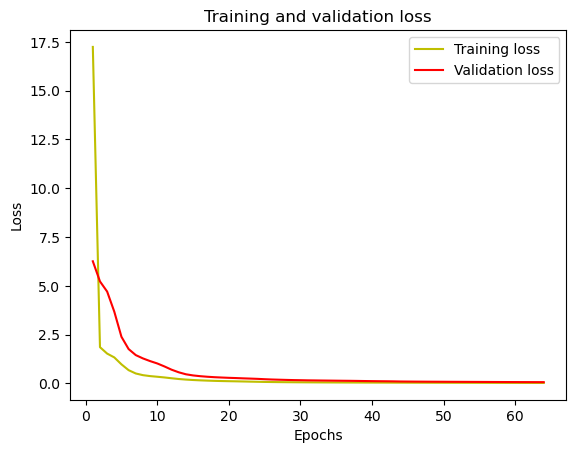

In [28]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# vae_loss 구성 요소 추출 함수 정의
def compute_vae_loss(x, reconstructed_x, z_mean, z_log_var):
    # Reconstruction loss
    reconstruction_loss = np.sum(np.square(x - reconstructed_x), axis=1)
    
    # KL divergence loss
    kl_loss = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)
    
    # Combine the losses (weighting applied to KL loss if needed)
    total_loss = reconstruction_loss + kl_loss * 0.001  # Example: KL weight = 0.001
    return total_loss

# X_test에 대한 reconstructed data 계산
z, z_mean, z_log_var = encoder.predict(X_test)  # 잠재 공간 정보 추출
predictions = decoder.predict(z)               # 복원 데이터 계산

# VAE loss 기반의 reconstruction error 계산
vae_error = compute_vae_loss(X_test, predictions, z_mean, z_log_var)

# reconstruction error와 실제 클래스를 담는 DataFrame 생성
error_df = pd.DataFrame({
    'VAE_error': vae_error,
    'True_class': y_test
})

print(error_df)

# 1(normal)에 대해서 훈련을 시켜놓은 VAE Model이기 때문에
# VAE_error가 높으면(잘 복원하지 못하면) 0(attack)으로 구분할 것임

       VAE_error  True_class
0       0.018189         1.0
1       0.013070         1.0
2       0.013410         1.0
3       0.012051         1.0
4       1.040487         1.0
...          ...         ...
38907   4.609746         0.0
38908   4.737253         0.0
38909   5.725430         0.0
38910   4.690765         0.0
38911   5.205617         0.0

[38912 rows x 2 columns]


In [37]:
threshold = 0.5

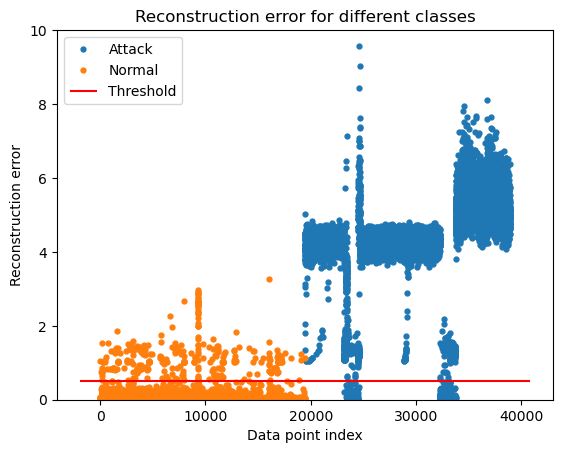

In [44]:
# y값 필터링
# error_df_test = error_df_test.reset_index()

groups = error_df.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.VAE_error, marker='o', ms=3.5, linestyle='',
            label="Normal" if name == 1 else "Attack")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 100 이하로 설정
ax.set_ylim(0, 10)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

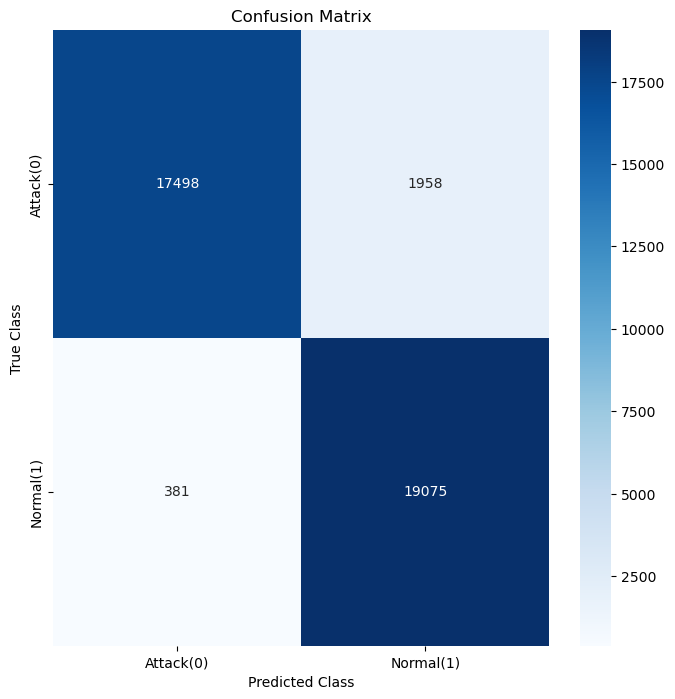

              precision    recall  f1-score   support

   Attack(0)       0.98      0.90      0.94     19456
   Normal(1)       0.91      0.98      0.94     19456

    accuracy                           0.94     38912
   macro avg       0.94      0.94      0.94     38912
weighted avg       0.94      0.94      0.94     38912



In [46]:
from sklearn.metrics import confusion_matrix, classification_report

# 정상 (1)과 공격 (0)을 나타내는 레이블
LABELS = ['Attack(0)', 'Normal(1)']

# Reconstruction error가 임계값(threshold)을 초과하면 Attack(0), 그렇지 않으면 Normal(1)로 예측
y_pred = [0 if e > threshold else 1 for e in error_df.VAE_error.values]

# 혼동 행렬 계산
conf_matrix = confusion_matrix(error_df.True_class, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# 분류 보고서 출력
print(classification_report(np.array(error_df.True_class), np.array(y_pred), target_names=LABELS))

VAE에서 **log variance**를 사용하는 이유는 주로 수치적 안정성과 계산의 간결성 때문입니다. 구체적으로는 아래의 이유 때문입니다:

---

### 1. **수치적 안정성**
- 분산(`variance`)은 항상 양수입니다. 이를 다룰 때, 특히 소규모의 값을 다룰 경우 **수치적인 문제**가 발생할 수 있습니다. 예를 들어, 분산이 아주 작다면 계산 과정에서 언더플로우가 발생할 위험이 있습니다.
- 로그 변환을 사용하면, 분산이 작더라도 로그 공간에서 더 넓은 범위로 표현됩니다. 이는 수치적으로 안정된 계산을 가능하게 합니다.

---

### 2. **지수 함수로 복원 가능**
- VAE에서는 샘플링을 위해 재매개변수화(reparameterization trick)를 사용하는데, 이 과정에서 분산 대신 표준편차의 형태로 사용됩니다.
- 로그-분산을 사용하면, 이를 지수 함수로 복원하여 표준편차(혹은 분산)를 쉽게 계산할 수 있습니다:
  \[
  \sigma = \exp(\frac{\log(\text{variance})}{2})
  \]

---

### 3. **KL-Divergence 계산의 간소화**
- VAE의 손실 함수에서 사용하는 KL 발산은 `z_mean`과 `z_log_var`를 사용해 간결하게 계산됩니다:
  \[
  D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
  \]
- 분산 대신 로그-분산을 사용하면, 로그 계산을 단순히 가져다 쓸 수 있어 표현과 코드 구현이 더 간결해집니다.

---

### 4. **학습의 안정화**
- 신경망에서 직접적으로 `variance`를 모델링하면 학습 도중 값이 폭발하거나 소멸할 위험이 있습니다.
- `log variance`를 학습하도록 하면 이런 문제를 방지할 수 있습니다.

---

### 요약
로그 분산(log variance)은 VAE에서:
1. 수치적 안정성 보장
2. 계산 간결화 (특히 KL 발산 계산)
3. 학습 안정성 증대  
등의 장점을 제공합니다. 